# Genetic Algorithm

We will be finding the shortest path between two POIs in vaughan using genetic algorithm.  

As you know there are a lot of variations you can do to do genetic algorithms, but we will assume the following in our implementation given the nature of our problem:

1. Fitness function is used to measure the length of the route.
2. We will be doing real-value GA, so our phenotype is the same as our genotype.
3. Our GA model is steady state, where we probablisically choose the best routes to be
   the parents of the next generation. We will deviate from the model a bit and would
   talk about that later.
4. We are doing 1-point crossover.
5. Mutation for a route is by deleting a random number of gene/node and trying to stitch that gap (TAKES TIME).
6. Selection is based on fitness-proportionate criteria.

We will explain these assumptions as we go on.

__GENETIC_ALGORITHM__ (_source_ , _destination_ , _num of generations_ , _pool size_) __returns__ a route  
&emsp;_pool_ &larr; _pool size_ random-routes between _source_ and _destination_  
&emsp;__for__ _num of generations_ __do__  
&emsp;&emsp; _parents first gen_ &larr; select number of best routes from _pool_  
&emsp;&emsp; _parents second gen_ &larr; crossover _parents first gen_     
&emsp;&emsp; _parents_ &larr; mutate _parents second gen_    
&emsp;&emsp; _pool_ &larr; offspring of _parents_  
&emsp;&emsp; remove duplicates from _pool_ and add random routes to compensate any removal  
&emsp;__endfor__  
&emsp;_route_ &larr; best route in _pool_  
&emsp;__return__ _route_  

In [1]:
import osmnx as ox
import itertools, heapq, random
from tqdm import tqdm
from utilities import *

We didn't use UofT route because the algorithm converges to the optimal solution rather quickly, so we went for a bigger map.

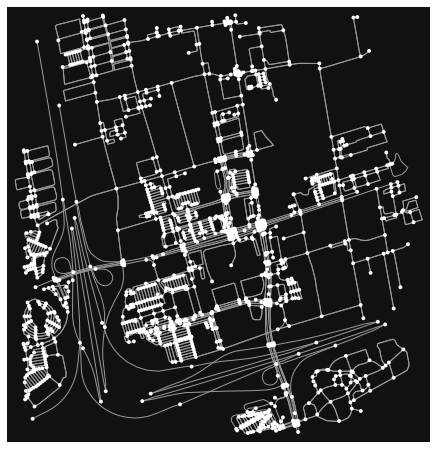

In [2]:
G = ox.graph_from_address('vaughan', dist= 1400)
fig, ax = ox.plot_graph(G)

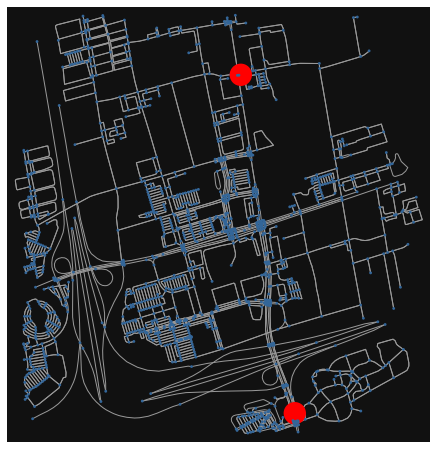

In [3]:
origin = 29658954
destination = 7426780162

highlighted = [origin, destination]

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [500 if node in highlighted else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [ ]:
draw_map(G, highlight = highlighted)

The graph has 1413 which is a lot, we will use basic faster folium instead


comment the magic work %%capture to see the implementation of the following objects/functions

In [ ]:
%%capture
source(Node)

We need to generate a random paths from source and destination to generate the first population. The following algorithm is just a variant of the typical graph search but instead of choosing the node to be expanded based on a certain determinstric policy like bfs/dfs, we just choose the node randomly from the frontier.

In [ ]:
%%capture
source(randomized_search)

## Implementation details

We needed to improvise a lot to build up heuristic producing good and scalable solution, because we need to deal with a route with specified source and destination.

1. Mutation:  
    Mutating a path with specified source node and destination node is done by deleting/failing a random node 
    between these two node, which results into a disconnected route. We remedy that gap by stitching the disconnected
    route with the shortest path between the node before the failed node and the node after the failed node.
    
    We do this by deleting the failed node from the graph as if it didn't exist at all, so the two nodes (before and       after) get connected by some other way than the failed node. We can't fail any node and there are other considerations that you can read about in the function documentation at `utilities/src/common.py`. 
    
    Think about individual node in the route as allele that we knock our and replace with possible more than one so we end up with a complete route between source and destination.  
    
    
2. Crossover:
    We have two routes with the same source and destination, what we do is exactly like the typical 1-point crossover except we don't "randomly" choose a point for splitting. We search both routes to find a node that is common between them and split at that node.  
    
    
3. Offspring:
   We have talked about this issue of generating children of a route, but here we go again 🧉. We needed to have a deteminstic policy for generating children from a route between specific two nodes. Of course we can't change the first and last node in the route, as they are the source and destination of the route, and we can't just generate permutations of the nodes between them because the graph isn't fully connected and would lead to inadmissible routes. What we do is the same procedure as the mutation method but without choosing the node randomly, we first fail a single node starting from the second node until the node $N-1$ if we have a route with $N$ route and generate a child after stitching the route after the failure. This first pass of successively failing a single node generates $N-2$ children, and at the second pass we fail 2 successive nodes at once starting with the second and third node until the nodes $N-2$ and $N-1$. At the last pass we fail every node between source and destination and we try to find the shortest path between source and destination in the graph without considering any of these nodes. Trying to generate that last child is not a good idea and even infeasible in some situation if we have a lot of node, and if we could find this child why don't you just generate it and terminate your algorithm. So a single route with $N$ route would generate $O(((N-2)+1)*(N-2))/2)$ child, but don't ever generate more that 5-10 children.
   
4. Duplicates:
    Our offspring generation algorithm generates a lot of duplicates that needs to be cleaned before going into the next generation because all the routes are very close to each other. That is where we deviate from the steady-state model and clean those duplicates and add random routes in the pool to compensate this removal, which also helps on diversify your population.

In [ ]:
%%capture
# comment capture to see the source code of these methods
source(mutate)  
source(cross_over)

## GA parameters

In [ ]:
# number of generation
ngen = 20
# size of population; # of routes
pool_size = 15
# number of parents that pass their genotype to the next generation
# make sure parents_num and pool_size are multiples 
parents_num = 3

Initializing the starting population with random routes between the source and destination

In [ ]:
pool = [randomized_search(G, origin, destination) for _ in range(pool_size)]

This would take some time -- about 2 minutes per iteration/generation

In [ ]:
states = []
for generation in tqdm(range(ngen)):
    # so we can select a route probabilistically based on its fitness value
    # this is roulette wheel selection
    weights = [cost(G, route) for route in pool]
    parents_1 = select_best(pool, parents_num, weights)

    # crossover between every possible pair in the parents list 
    # this generates (nP2) routes because itertools.product function
    # generate the cartesian product of the set so we select the best and smallest ones 
    parents_2 = [cross_over(route_1, route_2) for route_1, route_2 in itertools.product(parents_1, repeat = 2)]
    parents_2 = heapq.nsmallest(parents_num ,parents_2, key = lambda route : cost(G, route))
    
    # mutate parents before offspring
    parents = [mutate(G, route) for route in parents_2]

    # generate the offspring of these parents -- each 10 parent will generate 30/10=3 child
    pool = flatten([[*itertools.islice(children_route(G, route), pool_size // parents_num)] for route in parents])
    
    # this is to remove duplicates from the pool -- implementation detail
    pool = [*map(list, list(set(map(tuple, pool))))]
    
    # see how many routes have been removed and compensate for that to have pool_size pool 
    # at every iteration. 
    num_removed = pool_size - len(pool) + 1
    pool.extend([randomized_search(G, origin, destination) for _ in range(num_removed)])
    
    # to track the shortest route at each iteration
    states.append(cost(G, min(pool, key = lambda route : cost(G, route))))

route = min(pool, key = lambda route : cost(G, route))


remember that the optimal value is 2320-ish meters

In [ ]:
cost(G, route)

In [ ]:
draw_route(G, route)

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("number of generation")
plt.ylabel("cost of the shortest route (meters)")
plt.plot(states)
plt.show()